In [1]:
# import libraries
from datetime import datetime
from os import listdir
import csv
import os
from os.path import isfile, join
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wave
from scipy.stats import zscore
import statsmodels.api as sm
#from modwt import modwt, modwtmra
import librosa
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score, precision_score, recall_score, f1_score
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout,BatchNormalization,ReLU,Bidirectional,LSTM,TimeDistributed, Reshape
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.losses import SumOfSquares
import tensorflow as tf
import pywt
import pandas
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
#from keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_test = pd.read_csv("/content/drive/MyDrive/Lungs_Model/train_test_set.txt",
                         header = None,sep='_|	|[|]',engine='python')
train_test.columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode ','Recording equipment','TrainTestStatus']
train_test.to_csv('ICBHI_challenge_train_test.csv')

In [4]:
train_test

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment,TrainTestStatus
0,101,1b1,Al,sc,Meditron,test
1,101,1b1,Pr,sc,Meditron,test
2,102,1b1,Ar,sc,Meditron,test
3,103,2b2,Ar,mc,LittC2SE,train
4,104,1b1,Al,sc,Litt3200,test
...,...,...,...,...,...,...
915,224,1b2,Al,sc,Meditron,test
916,225,1b1,Pl,sc,Meditron,test
917,226,1b1,Al,sc,Meditron,train
918,226,1b1,Ll,sc,Meditron,train


In [5]:
mypath = "/content/drive/MyDrive/Lungs_Model/dataset"
audio_wav = [f for f in os.listdir(mypath) if f.endswith('.wav')] #contains name of each audio wav file
p_id_in_file = [] # patient IDs corresponding to each file
for name in audio_wav:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)# contains patient number of each audio file
print(len(p_id_in_file))

920


In [6]:
diagnosis=pd.read_csv("/content/drive/MyDrive/Lungs_Model/diagnosis.txt",header = None,delimiter='	')
diagnosis.columns = ['Patient number','Health Status']
diagnosis.to_csv('ICBHI_Challenge_diagnosis.csv')

In [7]:
diagnosis

,Patient number,Health Status
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [8]:
demographic_data=pd.read_csv("/content/drive/MyDrive/Lungs_Model/demographic_info.txt",header = None,delimiter='	')
demographic_data.columns = ['Patient number','Age', 'Sex', 'Adult BMI (kg/m2)', 'Child Weight (kg)', 'Child Height (cm)']


In [9]:
demographic_data

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0
...,...,...,...,...,...,...
121,222,60.00,M,NaN,NaN,NaN
122,223,NaN,NaN,NaN,NaN,NaN
123,224,10.00,F,NaN,32.3,143.0
124,225,0.83,M,NaN,7.8,74.0


In [10]:
merge1 = diagnosis.merge(demographic_data, on='Patient number')

In [11]:
merged = merge1.merge(train_test, on='Patient number')

In [12]:
merged

,Patient number,Health Status,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Recording index,Chest location,Acquisition mode,Recording equipment,TrainTestStatus
0,101,URTI,3.00,F,NaN,19.0,99.0,1b1,Al,sc,Meditron,test
1,101,URTI,3.00,F,NaN,19.0,99.0,1b1,Pr,sc,Meditron,test
2,102,Healthy,0.75,F,NaN,9.8,73.0,1b1,Ar,sc,Meditron,test
3,103,Asthma,70.00,F,33.00,NaN,NaN,2b2,Ar,mc,LittC2SE,train
4,104,COPD,70.00,F,28.47,NaN,NaN,1b1,Al,sc,Litt3200,test
...,...,...,...,...,...,...,...,...,...,...,...,...
915,224,Healthy,10.00,F,NaN,32.3,143.0,1b2,Al,sc,Meditron,test
916,225,Healthy,0.83,M,NaN,7.8,74.0,1b1,Pl,sc,Meditron,test
917,226,Pneumonia,4.00,M,NaN,16.7,103.0,1b1,Al,sc,Meditron,train
918,226,Pneumonia,4.00,M,NaN,16.7,103.0,1b1,Ll,sc,Meditron,train


In [13]:
#List of Unique pateient fetched from Audio Files"
unique_patient_list = []
for x in p_id_in_file:
        # check if exists in unique_list or not
        if x not in unique_patient_list:
            unique_patient_list.append(x)
print(len(unique_patient_list))
print(unique_patient_list)

126
[203, 204, 205, 207, 206, 211, 210, 209, 208, 213, 217, 218, 216, 215, 214, 221, 219, 220, 222, 101, 224, 225, 226, 223, 104, 107, 102, 106, 109, 110, 111, 117, 114, 118, 113, 112, 116, 124, 122, 120, 123, 121, 130, 129, 128, 133, 134, 135, 138, 137, 136, 140, 139, 141, 145, 146, 144, 143, 147, 151, 150, 149, 154, 153, 152, 156, 155, 158, 160, 159, 162, 161, 163, 165, 166, 170, 167, 169, 172, 171, 174, 175, 176, 177, 178, 183, 185, 184, 181, 182, 186, 191, 188, 192, 187, 193, 198, 195, 194, 200, 199, 201, 212, 103, 105, 108, 115, 119, 127, 125, 126, 131, 132, 142, 148, 157, 168, 164, 173, 179, 180, 189, 190, 197, 196, 202]


In [14]:
#Reading Diagonsis File
p_diag = pd.read_csv("ICBHI_Challenge_diagnosis.csv")
#List of Unique Diagonsis Class
unique_class_list = []
for x1 in p_diag['Health Status']:
        # check if exists in unique_list or not
        if x1 not in unique_class_list:
            unique_class_list.append(x1)
print("\nNo of Diagnosis Cases : \n......................\n",len(unique_class_list))
print("\nDiagnosis Classes : \n...................\n",unique_class_list)


No of Diagnosis Cases : 
......................
 8

Diagnosis Classes : 
...................
 ['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis', 'Pneumonia', 'Bronchiolitis']


In [15]:
string_counts = Counter(list(merged['Health Status']))
# contains the number of times each disease occurs
string_counts_dict = dict(string_counts)

In [16]:
string_counts_dict

{'URTI': 23,
 'Healthy': 35,
 'Asthma': 1,
 'COPD': 793,
 'LRTI': 2,
 'Bronchiectasis': 16,
 'Pneumonia': 37,
 'Bronchiolitis': 13}

In [17]:
weights = []
for i in string_counts_dict :
  weights.append(1 - string_counts_dict[i]/920)



In [18]:
weights

[0.975,
 0.9619565217391304,
 0.9989130434782608,
 0.1380434782608696,
 0.9978260869565218,
 0.9826086956521739,
 0.9597826086956521,
 0.9858695652173913]

In [19]:
#List of Healthy & Unhelathy
Healthy=[]
Unhealthy=[]
for H in range(125):
    #if H not in Healthy:
        if p_diag['Health Status'][H] == "Healthy":
          Healthy.append(H)
        else:
         Unhealthy.append(H)

print("\nTotal Healthy Identified : \n..........................\n",len(Healthy))
print("\nTotal Unealthy Identified : \n..........................\n",len(Unhealthy))


Total Healthy Identified : 
..........................
 26

Total Unealthy Identified : 
..........................
 99


In [20]:
audio_txt = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.txt'))] #contains name of each audio txt file

In [21]:
# Specify the directory where your TXT files are located
txt_directory = '/content/drive/MyDrive/Lungs_Model/dataset'
columns= ["Start","End","Crackles","Wheezes"]
# Initialize an empty list to store DataFrames for each file's data
data_frames = []
rows_in_entry = []

# Iterate through the list of file names
for file_name in audio_txt:
    txt_file_path = os.path.join(txt_directory, file_name)

    # Check if the file exists
    if os.path.isfile(txt_file_path):
        # Read the data from the file into a DataFrame
        df = pd.read_csv(txt_file_path, delimiter='\t',header=None, names = columns)  # Adjust delimiter as needed
        df = df.reset_index(drop=True)
        # Append the DataFrame to the list
        data_frames.append(df)
        r = df.shape[0]
        rows_in_entry.append(r)
        # You can also process or analyze the data in each DataFrame as needed
    else:
        print(f"File '{file_name}' not found in the specified directory.")

#combined_df contains all respiratory cycles of all wav file
combined_df = pd.concat(data_frames, ignore_index=True,axis = 0)

# rows_in_entry contains number of respiratory cycle in each wave file
row_in_entry = pd.DataFrame(rows_in_entry) # rows_in_entry contains number of respiratory cycle in each wave file


In [22]:
# wavfilename variable contains name of each wav file
# eg : '122_2b3_Tc_mc_LittC2SE.wav'

wavfilename = []
for name in audio_wav:
    wavfilename.append(name)

In [23]:
np.array(audio_txt).shape

(920,)

In [24]:
np.array(audio_wav).shape

(920,)

In [25]:
merged_list = merged.values.tolist()  # converting to list to extract element through indexing

In [26]:
merged_list[0]

[101, 'URTI', 3.0, 'F', nan, 19.0, 99.0, '1b1', 'Al', 'sc', 'Meditron', 'test']

In [27]:
minidata = [] # contains data without wave file start end and type of noise

wavefilename = []
for i in range(len(p_id_in_file)):
  for j in range(rows_in_entry[i]):
    minidata.append(merged_list[i])
    wavefilename.append(wavfilename[i])

minidata= pd.DataFrame(minidata,columns = ['Patient number','Health Status','Age', 'Sex', 'Adult BMI (kg/m2)', 'Child Weight (kg)', 'Child Height (cm)','Recording index','Chest location','Acquisition mode ','Recording equipment','TrainTestStatus'])
wavefilename = pd.DataFrame(wavefilename,columns = ["File Name"])

In [28]:
metadata = pd.concat([minidata, combined_df,wavefilename], axis=1)

In [29]:
metadata #all data of particular recording

,Patient number,Health Status,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Recording index,Chest location,Acquisition mode,Recording equipment,TrainTestStatus,Start,End,Crackles,Wheezes,File Name
0,101,URTI,3.0,F,NaN,19.0,99.0,1b1,Al,sc,Meditron,test,0.077,3.018,0,0,203_1p4_Ar_mc_AKGC417L.wav
1,101,URTI,3.0,F,NaN,19.0,99.0,1b1,Al,sc,Meditron,test,3.018,5.756,0,0,203_1p4_Ar_mc_AKGC417L.wav
2,101,URTI,3.0,F,NaN,19.0,99.0,1b1,Al,sc,Meditron,test,5.756,8.958,0,0,203_1p4_Ar_mc_AKGC417L.wav
3,101,URTI,3.0,F,NaN,19.0,99.0,1b1,Al,sc,Meditron,test,8.958,11.958,0,0,203_1p4_Ar_mc_AKGC417L.wav
4,101,URTI,3.0,F,NaN,19.0,99.0,1b1,Al,sc,Meditron,test,11.958,14.946,0,0,203_1p4_Ar_mc_AKGC417L.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1,Pl,sc,Meditron,train,9.351,11.851,0,0,203_2p3_Al_mc_AKGC417L.wav
6894,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1,Pl,sc,Meditron,train,11.851,14.244,0,0,203_2p3_Al_mc_AKGC417L.wav
6895,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1,Pl,sc,Meditron,train,14.244,16.744,1,0,203_2p3_Al_mc_AKGC417L.wav
6896,226,Pneumonia,4.0,M,NaN,16.7,103.0,1b1,Pl,sc,Meditron,train,16.744,19.125,1,1,203_2p3_Al_mc_AKGC417L.wav


In [30]:
# file_path = 'dataset/' + str(metadata['File Name'].values[2222])
# start_time = metadata['Start'].values[0]
# end_time = metadata['End'].values[0]

#def resp_cycle(filename,start,end):

In [31]:
# def load_data():
#         X, y = [], []
#         for file_path in data_path:
#             audio, _ = librosa.load(file_path, sr=sampling_rate, duration=duration, offset=0.0)
#             X.append(audio)
#             label = file_path.split('/')[-2]
#             y.append(label)
#         return X, y

In [32]:
# y_tar = merged['Health Status']

In [33]:
# np.array(y_tar).shape

In [34]:
len(wavfilename)

920

In [35]:
def load_data():
        X, y = [], []
        for i in range(len(wavfilename)):
            file_path = '/content/drive/MyDrive/Lungs_Model/dataset/' + str(wavfilename[i])
            audio, _ = librosa.load(file_path, sr=4000, duration=5, offset=0.0)
            X.append(audio)
            #y.append(y_tar[i])
        return X

In [36]:
X = load_data()

In [37]:
X = np.array(X)

In [38]:
X

array([[ 8.9183814e-08,  7.7565318e-08,  5.8216813e-08, ...,
        -5.4620016e-01, -5.0929451e-01, -5.7350886e-01],
       [ 1.3903266e-10, -3.8651721e-13,  3.9679648e-10, ...,
        -2.4579668e-03, -2.2820407e-03, -3.3731973e-03],
       [ 5.2657377e-08,  2.1191809e-08,  7.0291534e-08, ...,
         3.3567891e-01,  3.1053537e-01,  3.3709693e-01],
       ...,
       [-2.8313822e-08,  2.7812142e-08,  9.6221013e-09, ...,
        -3.7478045e-02, -7.9668596e-02, -1.3037384e-01],
       [-2.8690405e-08, -1.2922692e-08, -3.6667561e-08, ...,
         4.9732439e-03,  2.0911863e-02,  5.1048033e-02],
       [-2.5025908e-08, -2.1708142e-09,  4.7237886e-08, ...,
         3.2601304e-02,  4.0930476e-02,  5.8905099e-02]], dtype=float32)

In [39]:
def preprocessing(audio):
    wavelet = 'db5'
    level = 4
    coeffs = pywt.wavedec(audio, wavelet, level=level, mode='per')
    threshold = 0.05
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    wavelet_smoothed_audio = pywt.waverec(coeffs_thresholded, wavelet, mode='per')
    loess = sm.nonparametric.lowess(wavelet_smoothed_audio, np.arange(len(wavelet_smoothed_audio)), frac=0.001)
    loess_audio = loess[:, 1]
    audio_z=zscore(loess_audio,axis=0)

    return audio_z



In [40]:
audio = preprocessing(X[10])

In [41]:
time = np.linspace(0, 5, len(audio))

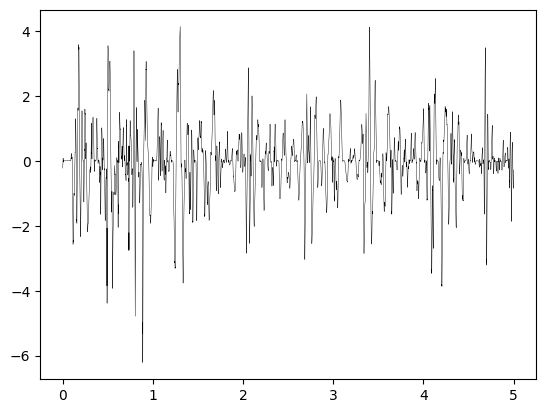

In [42]:
plt.plot(time,audio,lw = 0.3,color='k')

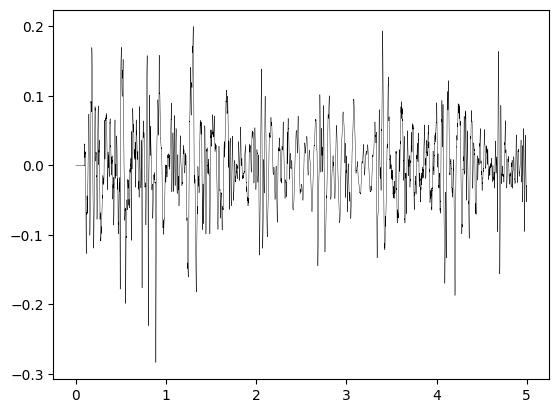

In [43]:
plt.plot(time,X[10],lw=0.3,color = 'k')

In [44]:
# X_preprocessed = []
# for i in range(len(wavfilename)):
#     audio = preprocessing(X[i])
#     X_preprocessed.append(audio)
#     print(i)


In [45]:

# Save the array to a file
#np.save("preprocessed.npy",X_preprocessed)


In [46]:
loaded_X_preprocessed = np.load("/content/drive/MyDrive/Lungs_Model/preprocessed.npy")


In [47]:
class_dict = {0 : 'Asthma',1 : 'Bronchiectasis', 2 : 'Bronchiolitis',3 : 'COPD', 4 : 'Healthy',5 : 'LRTI',6 : 'Pneumonia',7 : 'URTI'}

In [48]:
from sklearn.preprocessing import OneHotEncoder

#label_encoder = preprocessing.OneHotEncoder()
# y_tar = y_tar.astype('category')
# enc = OneHotEncoder()
# y_tar = y_tar.cat.codes
# enc_data = pd.DataFrame(enc.fit_transform(y_tar).toarray())

#df = load_dataset('penguins')
ohe = OneHotEncoder()
transformed = ohe.fit_transform(merged[['Health Status']])
transformed.toarray()
#transformed1 = pd.DataFrame(transformed)
#transformed.columns = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy','LRTI', 'Pneumonia', 'URTI']



array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [49]:
print(ohe.categories_)

[array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI'], dtype=object)]


In [50]:
merged[ohe.categories_[0]] = transformed.toarray()

In [51]:
merged

,Patient number,Health Status,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Recording index,Chest location,Acquisition mode,Recording equipment,TrainTestStatus,Asthma,Bronchiectasis,Bronchiolitis,COPD,Healthy,LRTI,Pneumonia,URTI
0,101,URTI,3.00,F,NaN,19.0,99.0,1b1,Al,sc,Meditron,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,101,URTI,3.00,F,NaN,19.0,99.0,1b1,Pr,sc,Meditron,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,102,Healthy,0.75,F,NaN,9.8,73.0,1b1,Ar,sc,Meditron,test,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,103,Asthma,70.00,F,33.00,NaN,NaN,2b2,Ar,mc,LittC2SE,train,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,104,COPD,70.00,F,28.47,NaN,NaN,1b1,Al,sc,Litt3200,test,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,224,Healthy,10.00,F,NaN,32.3,143.0,1b2,Al,sc,Meditron,test,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
916,225,Healthy,0.83,M,NaN,7.8,74.0,1b1,Pl,sc,Meditron,test,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
917,226,Pneumonia,4.00,M,NaN,16.7,103.0,1b1,Al,sc,Meditron,train,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
918,226,Pneumonia,4.00,M,NaN,16.7,103.0,1b1,Ll,sc,Meditron,train,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
y_tar = merged[['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy','LRTI', 'Pneumonia', 'URTI']]

In [53]:
y_target = y_tar.to_numpy()

In [54]:
y_target

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [55]:
model = Sequential()

# Add a 1D input layer
model.add(tf.keras.layers.Input(shape=(20000, 1)))

# Add three Conv1D layers with batch normalization and ReLU
model.add(Conv1D(filters=16, kernel_size=32, strides=1)),
model.add(BatchNormalization()),
model.add(ReLU()),
model.add(Dropout(0.3)),

model.add(Conv1D(filters=16, kernel_size=32, strides=1)),
model.add(BatchNormalization()),
model.add(ReLU()),
model.add(Dropout(0.3)),

model.add(Conv1D(filters=16, kernel_size=32, strides=1)),
model.add(MaxPooling1D(pool_size=2, strides=2)),
model.add(BatchNormalization()),
model.add(ReLU()),

model.add(Flatten()),

model.add(Reshape((model.output_shape[1], 1)))

model.add(Bidirectional(LSTM(100, return_sequences=False)))

model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))

model.add(Dense(units = 8,activation = 'softmax'))





In [56]:
# # Flatten the output to prepare for the fully connected layers
# #model.add(Dense(number_of_classes, activation='softmax'))

# # Compile the model
# #model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error', metrics=['accuracy'])

# # Define the number of epochs and mini-batch size
# num_epochs = 5
# batch_size = 64

# # Train the model with 10-fold cross-validation (You will need to set up your cross-validation data splits)
# for fold in range(10):
#     model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size, validation_data=(val_data, val_labels))

# # Add L2 regulariza8ition
# model.add(keras.regularizers.l2(0.0001))

# # Calculate the weights for each class
# total_samples = len(all_labels)
# class_samples = [sum(all_labels == c) for c in range(number_of_classes)]
# class_weights = [1 - (ns / total_samples) for ns in class_samples]

# # Define a custom loss function that applies the weighted sum of squares error
# def weighted_sse(y_true, y_pred):
#     return tf.reduce_sum(class_weights * tf.square(y_true - y_pred))

# # Compile the model with the custom loss function
# #model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss=weighted_sse, metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19969, 16)         528       
                                                                 
 batch_normalization (Batch  (None, 19969, 16)         64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 19969, 16)         0         
                                                                 
 dropout (Dropout)           (None, 19969, 16)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 19938, 16)         8208      
                                                                 
 batch_normalization_1 (Bat  (None, 19938, 16)         64        
 chNormalization)                                       

In [58]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
X_train, X_test_val, y_train, y_test_val = train_test_split(loaded_X_preprocessed, y_target, test_size=0.3, random_state=42)


# Splitting the temporary set into testing and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)


In [60]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


(644, 20000)
(138, 20000)
(138, 20000)
(644, 8)
(138, 8)
(138, 8)


In [61]:
import time  # Import the time module

class BatchCounterCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        self.data_processed = 0

    def on_batch_end(self, batch, logs=None):
        batch_size = logs.get('size', 0)
        self.data_processed += batch_size

    def on_epoch_end(self, epoch, logs=None):
        epoch_end_time = time.time()
        print(f"Epoch {epoch + 1}: {self.data_processed} data points processed in {epoch_end_time - self.epoch_start_time} seconds")

In [62]:
history = model.fit(X_train, y_train, batch_size=8, epochs=4, validation_data=(X_val, y_val),callbacks=[BatchCounterCallback()], verbose = 1)

Epoch 1/4
81/81 [==============================] - 798s 10s/step - loss: 0.7996 - accuracy: 0.8618 - val_loss: 0.8297 - val_accuracy: 0.8116
Epoch 2/4
81/81 [==============================] - 748s 9s/step - loss: 0.6036 - accuracy: 0.8742 - val_loss: 0.8652 - val_accuracy: 0.8116
Epoch 3/4
81/81 [==============================] - 773s 10s/step - loss: 0.6078 - accuracy: 0.8742 - val_loss: 0.8396 - val_accuracy: 0.8116
Epoch 4/4
81/81 [==============================] - 745s 9s/step - loss: 0.6144 - accuracy: 0.8742 - val_loss: 0.8829 - val_accuracy: 0.8116


In [63]:
model.save('/content/drive/MyDrive/Lungs_Model/trained_model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
#model = tf.keras.models.load_model('/content/drive/MyDrive/Lungs_Model/trained_model.h5')

In [65]:
score = model.evaluate(X_test, y_test, batch_size=4, verbose=1)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])



35/35 [==============================] - 103s 3s/step - loss: 0.6599 - accuracy: 0.8551
Accuracy: 86%
Loss: 0.6599



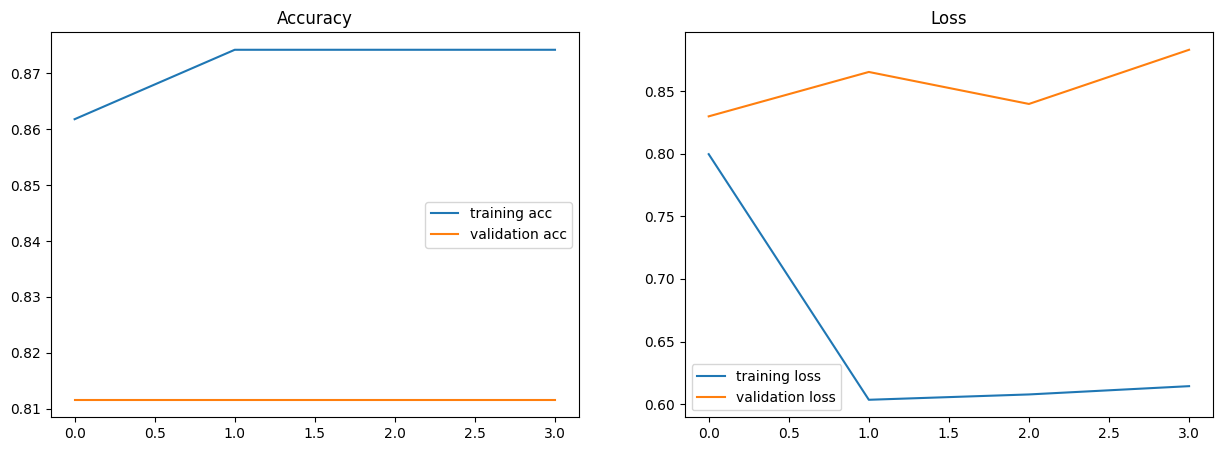

In [69]:
#Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [67]:
# Load and preprocess your data
# X_train, y_train, X_test, y_test = load_and preprocess_data()

# Train the model
# model.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test))

# Evaluate the model on test data
y_pred = model.predict(X_test,batch_size = 4)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(y_pred)
print(y_pred_classes)
print(y_true)


print(classification_report(y_true, y_pred_classes))

# print(accuracy_score(y_true ,y_pred_classes))
# print(confusion_matrix(y_true, y_pred_classes))


# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_true, y_pred_classes)
kappa = cohen_kappa_score(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
sensitivity = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')


35/35 [==============================] - 129s 4s/step
[[0.00101831 0.00631597 0.00914353 ... 0.00215553 0.02619246 0.01863443]
 [0.00139267 0.0082235  0.01089643 ... 0.00280377 0.02874437 0.02193259]
 [0.00066279 0.00444058 0.00706004 ... 0.00147819 0.02230075 0.01425127]
 ...
 [0.00071545 0.00473502 0.0073864  ... 0.0015815  0.02290333 0.01488707]
 [0.00112674 0.00687546 0.00961695 ... 0.00231954 0.02669655 0.01943499]
 [0.00123323 0.00745039 0.01015672 ... 0.00253168 0.02759926 0.02044851]]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 3 3 3 3 3 3 3 3 3 7 3 3 1 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 6 4 3 3 3 3 4 3 3 3 3 2 3 3 3 6 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 7 3 3 1 3 3 3 3 4 4 3 3 3 3 7 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
print(conf_matrix)
print(kappa)
print(accuracy)
print(sensitivity)

[[  0   0   3   0   0   0]
 [  0   0   1   0   0   0]
 [  0   0 118   0   0   0]
 [  0   0   7   0   0   0]
 [  0   0   5   0   0   0]
 [  0   0   4   0   0   0]]
0.0
0.855072463768116
0.855072463768116
